# Outlier Detection and Diabetes Prediction on the Pima Indians Dataset

This notebook demonstrates a complete workflow for preprocessing the Pima Indians Diabetes dataset, including outlier detection and removal, followed by training a classification model to predict diabetes. All code uses up-to-date libraries and techniques.

## 1. Load the Pima Indians Dataset

We will load the dataset, which should be placed in the working directory as `pima-indians-diabetes.csv`. This dataset contains various medical predictor variables and one target variable, `Outcome`, indicating whether a patient has diabetes.

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'C:\Users\macma\PycharmProjects\PimaIndiandsDiabetes\notebooks\data\diabetes.csv')

# Display basic information
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Exploratory Data Analysis (EDA)

Let's examine the basic statistics of the dataset and look for missing or anomalous values.

In [3]:
import numpy as np

# Basic info and statistics
print(df.info())
print(df.describe())

# Check for zeros in columns where they are not medically possible
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_columns:
    num_zero = (df[col] == 0).sum()
    print(f"{col} has {num_zero} zero values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

## 3. Handling Missing Values

Some features use 0 to indicate missing values. We'll replace zeros with the median of the column.

In [4]:
# Replace zeros with median for specific columns
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    median_val = df[df[col] != 0][col].median()
    df.loc[df[col] == 0, col] = median_val

# Verify replacement
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    num_zero = (df[col] == 0).sum()
    print(f"After replacement, {col} has {num_zero} zero values")

After replacement, Glucose has 0 zero values
After replacement, BloodPressure has 0 zero values
After replacement, SkinThickness has 0 zero values
After replacement, Insulin has 0 zero values
After replacement, BMI has 0 zero values


## 4. Outlier Detection and Removal

We'll use the IsolationForest algorithm from `scikit-learn` to identify and remove outliers from the dataset.

In [5]:
from sklearn.ensemble import IsolationForest

# Select features for outlier detection
features = df.drop(columns=['Outcome'])

# Initialize IsolationForest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit and predict outliers
outlier_labels = iso_forest.fit_predict(features)

# -1 indicates outlier, 1 indicates inlier
df['Outlier'] = outlier_labels

# Filter inliers only
df_clean = df[df['Outlier'] == 1].drop(columns=['Outlier']).reset_index(drop=True)

print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_clean.shape[0]}")

Original dataset size: 768
Cleaned dataset size: 729


## 5. Data Visualization

Let's visualize the distributions of key features before and after removing outliers.

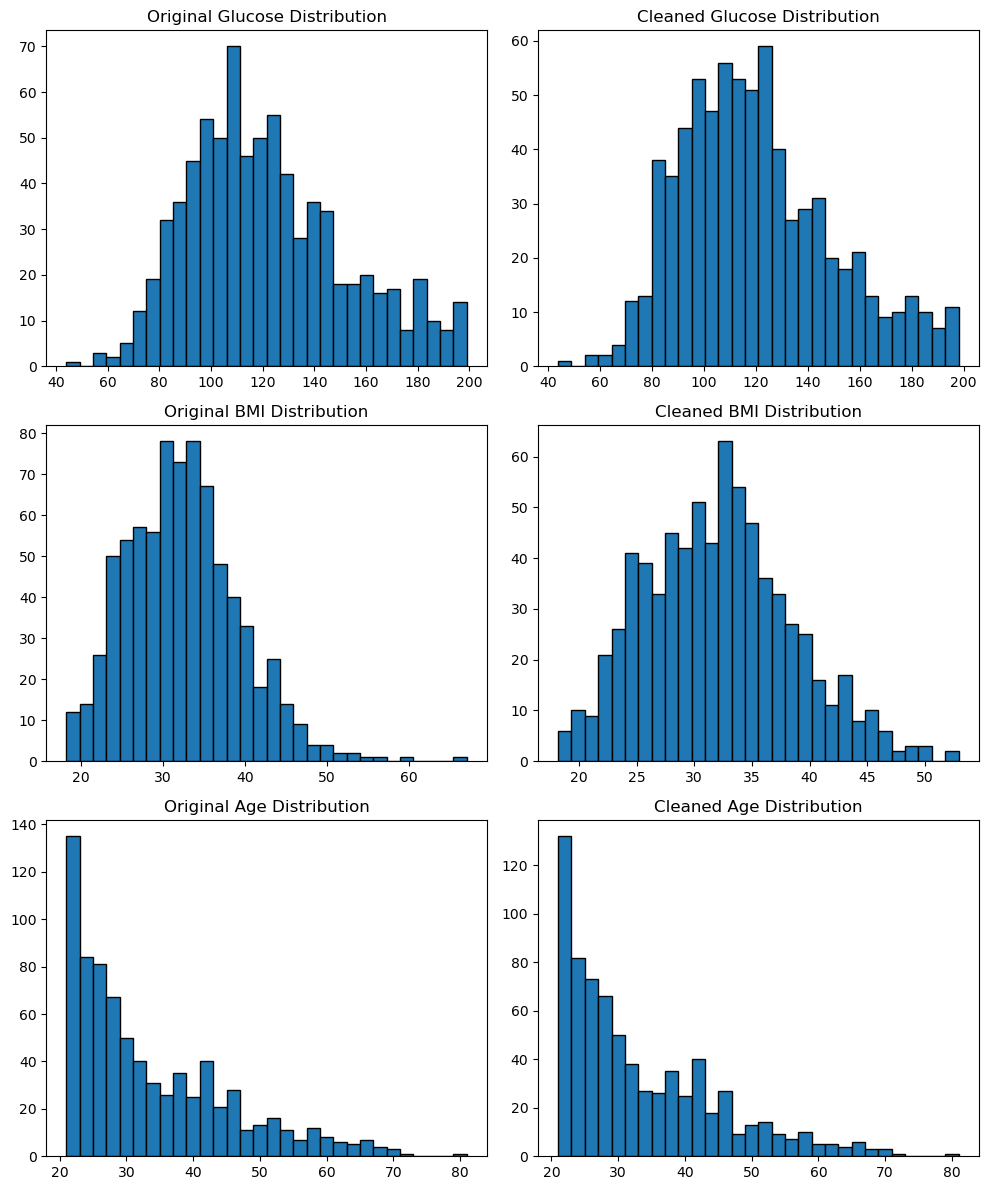

In [6]:
import matplotlib.pyplot as plt

# Plot distributions of selected features
features_to_plot = ['Glucose', 'BMI', 'Age']
fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(10, 12))

for i, col in enumerate(features_to_plot):
    axes[i, 0].hist(df[col], bins=30, edgecolor='k')
    axes[i, 0].set_title(f'Original {col} Distribution')

    axes[i, 1].hist(df_clean[col], bins=30, edgecolor='k')
    axes[i, 1].set_title(f'Cleaned {col} Distribution')

plt.tight_layout()
plt.show()

## 6. Model Training and Evaluation

Now we'll train a classification model. We'll split the cleaned data into training and testing sets, train a `RandomForestClassifier`, and evaluate its performance.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Separate features and target
X = df_clean.drop(columns=['Outcome'])
y = df_clean['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7808219178082192
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        98
           1       0.69      0.60      0.64        48

    accuracy                           0.78       146
   macro avg       0.75      0.74      0.74       146
weighted avg       0.78      0.78      0.78       146

Confusion Matrix:
[[85 13]
 [19 29]]


## 7. Feature Importance

Let's examine which features contributed most to the prediction.

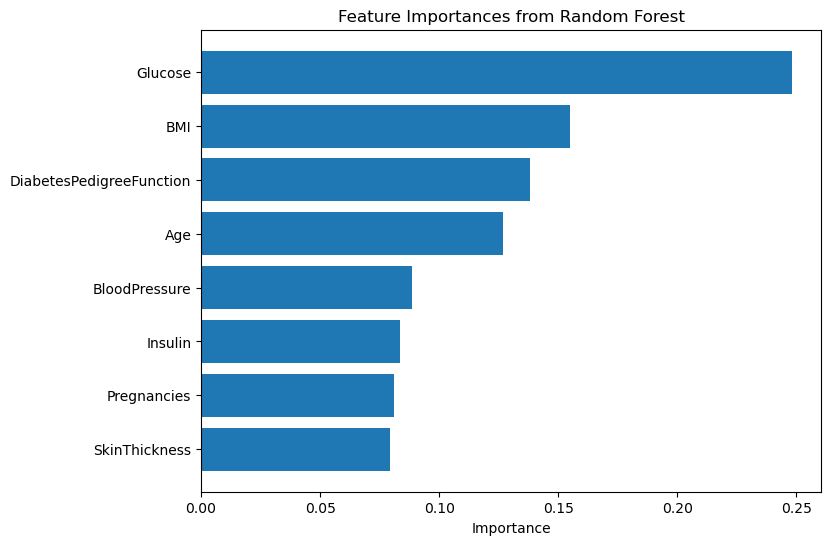

In [8]:
# Compute and plot feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(8, 6))
plt.barh(feature_names[indices], importances[indices])
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

## 8. Conclusion

In this notebook, we performed outlier detection using IsolationForest and built a Random Forest classifier to predict diabetes in the Pima Indians dataset. By removing outliers, we aimed to improve model performance and reliability.